--- All libraries imported. ---

--- Step 2: Downloading datasets... ---
--- Files downloaded successfully. ---

--- Step 3: Loading datasets into DataFrames... ---
--- DataFrames loaded successfully. ---
--- 'outputs/' and 'csv_files/' directories ensured. ---

--- Step 5: Cleaning data... ---
Successfully converted 'Timestamp IST' to datetime.
Trader data numeric columns cleaned and NaN dropped.
Successfully converted sentiment 'date' to datetime.

--- Step 6: Merging datasets... ---
--- Merge Complete. Final shape: (211218, 19) ---

--- Step 7: Performing Feature Engineering... ---
--- Feature Engineering Complete. 'merged_df' is ready. ---

--- Step 8: Running Analysis 1 (Profitability)... ---
--- Chart saved to outputs/1_avg_pnl_vs_sentiment.png ---


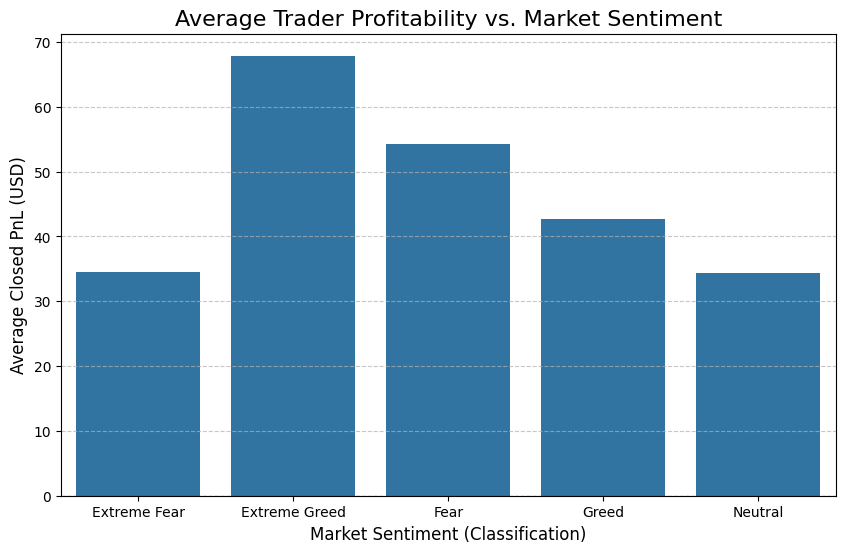


--- Step 9: Running Analysis 2 (Volume)... ---
--- Chart saved to outputs/2_volume_vs_sentiment.png ---


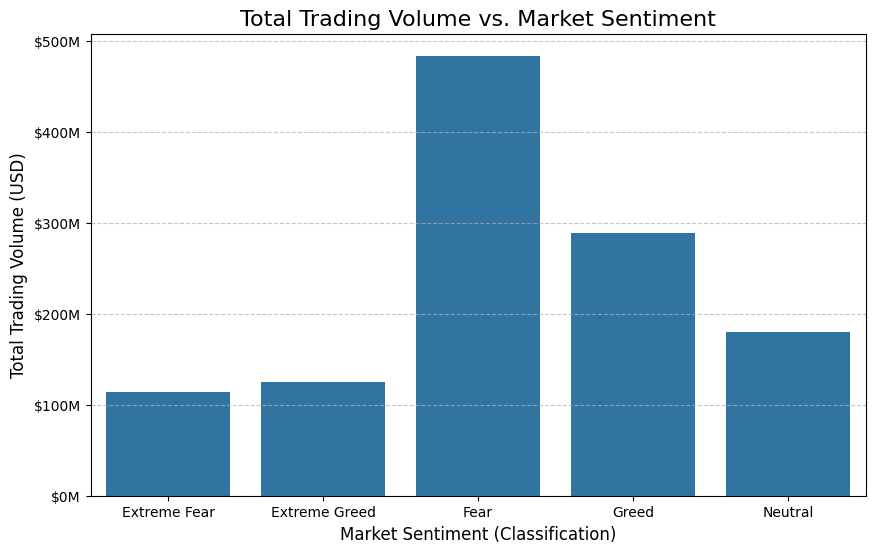


--- Step 10: Running Analysis 3 (All Trader Behavior)... ---
--- Chart saved to outputs/3_behavior_vs_sentiment.png ---


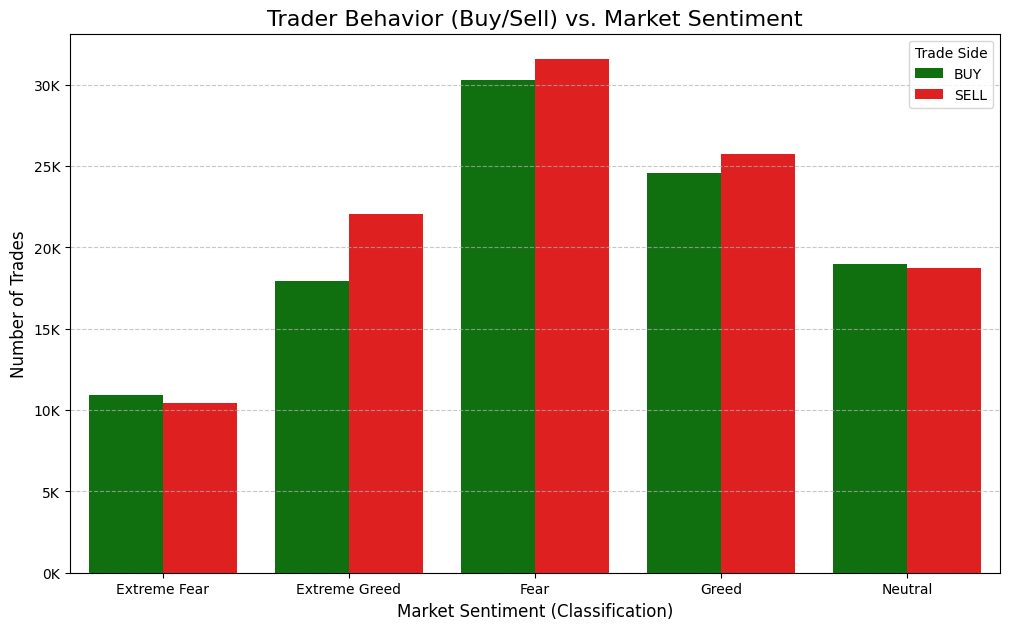


--- Step 11: Running Analysis 4 (Top Trader Behavior)... ---
Identified 4 top 10% traders.
--- Chart saved to outputs/4_top_trader_behavior.png ---


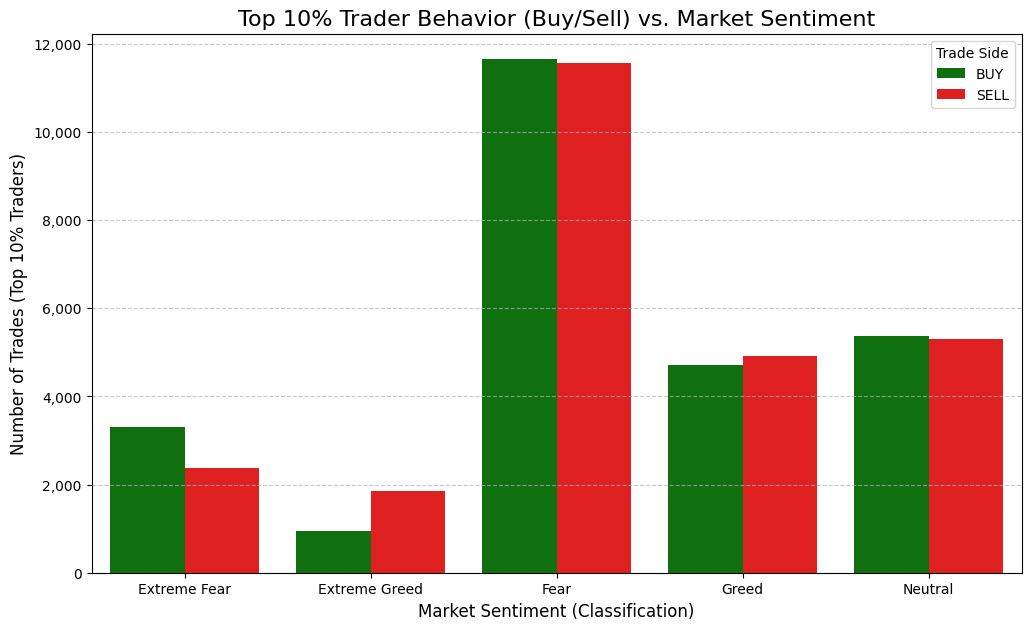


--- ENTIRE ANALYSIS COMPLETE. ---


In [1]:
# --- 0. Install required library ---
!pip install gdown

# --- 1. Import all necessary libraries ---
import pandas as pd
import gdown
import matplotlib.pyplot as plt
import seaborn as sns
import os
from matplotlib.ticker import FuncFormatter

print("--- All libraries imported. ---")

def run_analysis():
    """
    Main function to run the entire data analysis pipeline.
    """

    # --- 2. Download Datasets ---
    print("\n--- Step 2: Downloading datasets... ---")
    trader_data_id = '1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs'
    sentiment_data_id = '1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf'
    trader_data_file = 'historical_trader_data.csv'
    sentiment_data_file = 'fear_greed_index.csv'

    try:
        gdown.download(id=trader_data_id, output=trader_data_file, quiet=True)
        gdown.download(id=sentiment_data_id, output=sentiment_data_file, quiet=True)
        print("--- Files downloaded successfully. ---")
    except Exception as e:
        print(f"Error downloading files: {e}")
        return

    # --- 3. Load Datasets ---
    print("\n--- Step 3: Loading datasets into DataFrames... ---")
    try:
        trader_df = pd.read_csv(trader_data_file)
        sentiment_df = pd.read_csv(sentiment_data_file)
        print("--- DataFrames loaded successfully. ---")
    except Exception as e:
        print(f"Error loading CSVs: {e}")
        return

    # --- 4. Create 'outputs' Directory ---
    os.makedirs('outputs', exist_ok=True)
    os.makedirs('csv_files', exist_ok=True)
    print("--- 'outputs/' and 'csv_files/' directories ensured. ---")

    # --- 5. Clean Data Types ---
    print("\n--- Step 5: Cleaning data... ---")

    # Clean Trader Data
    try:
        trader_df['Timestamp IST'] = pd.to_datetime(trader_df['Timestamp IST'], format='%d-%m-%Y %H:%M')
        print("Successfully converted 'Timestamp IST' to datetime.")
    except ValueError as e:
        print(f"Error converting 'Timestamp IST': {e}")
        return

    # Use correct column names identified from your data
    numeric_cols = ['Execution Price', 'Size Tokens', 'Size USD', 'Closed PnL']
    for col in numeric_cols:
        trader_df[col] = pd.to_numeric(trader_df[col], errors='coerce')
    trader_df.dropna(subset=numeric_cols, inplace=True)
    print("Trader data numeric columns cleaned and NaN dropped.")

    # Clean Sentiment Data
    try:
        # Use correct column name 'date'
        sentiment_df['date'] = pd.to_datetime(sentiment_df['date']).dt.normalize()
        print("Successfully converted sentiment 'date' to datetime.")
    except Exception as e:
        print(f"Error converting sentiment 'date': {e}")
        return

    # --- 6. Merge Datasets ---
    print("\n--- Step 6: Merging datasets... ---")
    trader_df['date_only'] = trader_df['Timestamp IST'].dt.normalize()
    merged_df = pd.merge(
        trader_df,
        sentiment_df,
        left_on='date_only',
        right_on='date',  # Use correct column 'date'
        how='left'
    )

    # Use correct column 'classification'
    merged_df.dropna(subset=['classification'], inplace=True)
    merged_df.drop(['date_only', 'date'], axis=1, inplace=True)
    print(f"--- Merge Complete. Final shape: {merged_df.shape} ---")

    # --- 7. Feature Engineering ---
    print("\n--- Step 7: Performing Feature Engineering... ---")
    merged_df['is_profit'] = merged_df['Closed PnL'] > 0
    print("--- Feature Engineering Complete. 'merged_df' is ready. ---")

    # --- 8. Analysis 1: Profitability vs. Sentiment ---
    print("\n--- Step 8: Running Analysis 1 (Profitability)... ---")
    pnl_by_sentiment = merged_df.groupby('classification')['Closed PnL'].mean().reset_index()
    plt.figure(figsize=(10, 6))
    sns.barplot(data=pnl_by_sentiment, x='classification', y='Closed PnL')
    plt.title('Average Trader Profitability vs. Market Sentiment', fontsize=16)
    plt.xlabel('Market Sentiment (Classification)', fontsize=12)
    plt.ylabel('Average Closed PnL (USD)', fontsize=12)
    plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    output_filename = 'outputs/1_avg_pnl_vs_sentiment.png'
    plt.savefig(output_filename)
    print(f"--- Chart saved to {output_filename} ---")
    plt.show()

    # --- 9. Analysis 2: Trading Volume vs. Sentiment ---
    print("\n--- Step 9: Running Analysis 2 (Volume)... ---")
    volume_by_sentiment = merged_df.groupby('classification')['Size USD'].sum().reset_index()
    plt.figure(figsize=(10, 6))
    sns.barplot(data=volume_by_sentiment, x='classification', y='Size USD')
    plt.title('Total Trading Volume vs. Market Sentiment', fontsize=16)
    plt.xlabel('Market Sentiment (Classification)', fontsize=12)
    plt.ylabel('Total Trading Volume (USD)', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    def millions_formatter(x, pos):
        return f'${x / 1_000_000:.0f}M'
    plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))
    output_filename = 'outputs/2_volume_vs_sentiment.png'
    plt.savefig(output_filename)
    print(f"--- Chart saved to {output_filename} ---")
    plt.show()

    # --- 10. Analysis 3: Trader Behavior (Side) vs. Sentiment ---
    print("\n--- Step 10: Running Analysis 3 (All Trader Behavior)... ---")
    behavior_by_sentiment = merged_df.groupby(['classification', 'Side']).size().reset_index(name='Trade Count')
    plt.figure(figsize=(12, 7))
    # Use uppercase 'BUY' and 'SELL' to match your data
    sns.barplot(data=behavior_by_sentiment, x='classification', y='Trade Count', hue='Side', palette={'BUY': 'g', 'SELL': 'r'})
    plt.title('Trader Behavior (Buy/Sell) vs. Market Sentiment', fontsize=16)
    plt.xlabel('Market Sentiment (Classification)', fontsize=12)
    plt.ylabel('Number of Trades', fontsize=12)
    plt.legend(title='Trade Side')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    def thousands_formatter(x, pos):
        return f'{x / 1_000:.0f}K'
    plt.gca().yaxis.set_major_formatter(FuncFormatter(thousands_formatter))
    output_filename = 'outputs/3_behavior_vs_sentiment.png'
    plt.savefig(output_filename)
    print(f"--- Chart saved to {output_filename} ---")
    plt.show()

    # --- 11. Analysis 4: Top Trader Behavior ("Hidden Pattern") ---
    print("\n--- Step 11: Running Analysis 4 (Top Trader Behavior)... ---")
    trader_profitability = merged_df.groupby('Account')['Closed PnL'].sum()
    top_10_percentile_threshold = trader_profitability.quantile(0.9)
    top_trader_accounts = trader_profitability[trader_profitability > top_10_percentile_threshold].index
    print(f"Identified {len(top_trader_accounts)} top 10% traders.")
    smart_traders_df = merged_df[merged_df['Account'].isin(top_trader_accounts)]
    top_trader_behavior = smart_traders_df.groupby(['classification', 'Side']).size().reset_index(name='Trade Count')

    plt.figure(figsize=(12, 7))
    sns.barplot(data=top_trader_behavior, x='classification', y='Trade Count', hue='Side', palette={'BUY': 'g', 'SELL': 'r'})
    plt.title('Top 10% Trader Behavior (Buy/Sell) vs. Market Sentiment', fontsize=16)
    plt.xlabel('Market Sentiment (Classification)', fontsize=12)
    plt.ylabel('Number of Trades (Top 10% Traders)', fontsize=12)
    plt.legend(title='Trade Side')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    def comma_formatter(x, pos):
        return f'{x:,.0f}'
    plt.gca().yaxis.set_major_formatter(FuncFormatter(comma_formatter))
    output_filename = 'outputs/4_top_trader_behavior.png'
    plt.savefig(output_filename)
    print(f"--- Chart saved to {output_filename} ---")
    plt.show()

    print("\n--- ENTIRE ANALYSIS COMPLETE. ---")

# --- Run the main function ---
run_analysis()